## Imports

In [22]:
import os
import warnings
import sys

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import mlflow
mlflow.entities.model_registry.ModelVersion
import mlflow.sklearn
import tarfile

from scipy.stats import randint
from six.moves import urllib
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    train_test_split,
)
from sklearn.tree import DecisionTreeRegressor


## MLflow Tracking server

The command used to set up the MLflow server is:
```
mlflow server --backend-store-uri mlruns/ --default-artifact-root mlruns/ --host localhost --port 5000
```

In [23]:
remote_server_uri = "http://localhost:5000" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)  # or set the MLFLOW_TRACKING_URI in the env

In [24]:
mlflow.tracking.get_tracking_uri()

'http://localhost:5000'

In [38]:
exp_name = "housing_price_prediction"
mlflow.set_experiment(exp_name)

<Experiment: artifact_location='mlruns/3', experiment_id='3', lifecycle_stage='active', name='housing_price_prediction', tags={}>

## Loading Dataset

In [26]:

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


fetch_housing_data()
housing = load_housing_data()

In [27]:
#function for data preparation (called below in mlflow function)
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


In [28]:
#function for model evaluation (called below in mlflow function)
def eval_metrics(actual, pred):
    # compute relevant metrics
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2


## MLflow function

Runs all child processes such as data cleaning and preparation, splitting of dataset, model training, model evaluation

In [39]:
param_distribs = {
    "n_estimators": randint(low=1, high=200),
    "max_features": randint(low=1, high=8),
}

def model(housing):
        with mlflow.start_run(run_name='PARENT_RUN') as parent_run:
            mlflow.log_param("parent", "yes")
            with mlflow.start_run(run_name='CHILD_RUN0.1', nested=True) as child_run_0_1:
                mlflow.log_param("child", "yes")
                housing["income_cat"] = pd.cut(
                housing["median_income"],
                bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                labels=[1, 2, 3, 4, 5],
                )


                split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
                for train_index, test_index in split.split(housing, housing["income_cat"]):
                    strat_train_set = housing.loc[train_index]
                    strat_test_set = housing.loc[test_index]
                #def income_cat_proportions(data):
                    #return data["income_cat"].value_counts() / len(data)


                train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

                compare_props = pd.DataFrame(
                    {
                    "Overall": income_cat_proportions(housing),
                    "Stratified": income_cat_proportions(strat_test_set),
                    "Random": income_cat_proportions(test_set),
                    }
                    ).sort_index()
                compare_props["Rand. %error"] = (
                100 * compare_props["Random"] / compare_props["Overall"] - 100
                )
                compare_props["Strat. %error"] = (
                100 * compare_props["Stratified"] / compare_props["Overall"] - 100
                )

                for set_ in (strat_train_set, strat_test_set):
                    set_.drop("income_cat", axis=1, inplace=True)

                housing = strat_train_set.copy()
                housing.plot(kind="scatter", x="longitude", y="latitude")
                housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

                corr_matrix = housing.corr()
                corr_matrix["median_house_value"].sort_values(ascending=False)
                housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
                housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
                housing["population_per_household"] = housing["population"] / housing["households"]

                housing = strat_train_set.drop(
                "median_house_value", axis=1
                )  # drop labels for training set
                housing_labels = strat_train_set["median_house_value"].copy()

                imputer = SimpleImputer(strategy="median")

                housing_num = housing.drop("ocean_proximity", axis=1)

                imputer.fit(housing_num)
                X = imputer.transform(housing_num)

                housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
                housing_tr["rooms_per_household"] = housing_tr["total_rooms"] / housing_tr["households"]
                housing_tr["bedrooms_per_room"] = (
                housing_tr["total_bedrooms"] / housing_tr["total_rooms"]
                )
                housing_tr["population_per_household"] = (
                housing_tr["population"] / housing_tr["households"]
                )

                housing_cat = housing[["ocean_proximity"]]
                housing_prepared = housing_tr.join(pd.get_dummies(housing_cat, drop_first=True))

            with mlflow.start_run(run_name='CHILD_RUN0.2', nested=True) as child_run_0_2:
                mlflow.log_param("child", "yes")
                X_test = strat_test_set.drop("median_house_value", axis=1)
                y_test = strat_test_set["median_house_value"].copy()
                X_test_num = X_test.drop("ocean_proximity", axis=1)
                X_test_prepared = imputer.transform(X_test_num)
                X_test_prepared = pd.DataFrame(
                X_test_prepared, columns=X_test_num.columns, index=X_test.index
                )
                X_test_prepared["rooms_per_household"] = (
                X_test_prepared["total_rooms"] / X_test_prepared["households"]
                )
                X_test_prepared["bedrooms_per_room"] = (
                X_test_prepared["total_bedrooms"] / X_test_prepared["total_rooms"]
                )
                X_test_prepared["population_per_household"] = (
                X_test_prepared["population"] / X_test_prepared["households"]
                )

                X_test_cat = X_test[["ocean_proximity"]]
                X_test_prepared = X_test_prepared.join(pd.get_dummies(X_test_cat, drop_first=True))

            with mlflow.start_run(run_name='CHILD_RUN1', nested=True) as child_run_1:
                mlflow.log_param("child", "yes")
                forest_reg = RandomForestRegressor(random_state=42)
                forest_reg.fit(housing_prepared, housing_labels)
                rnd_search = RandomizedSearchCV(
                forest_reg,
                param_distributions=param_distribs,
                n_iter=10, 
                cv=5,
                scoring="neg_mean_squared_error",random_state=42, )
                rnd_search.fit(housing_prepared, housing_labels)
                #cvres = rnd_search.cv_results_
                #for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
                  #print(np.sqrt(-mean_score), params)
                predrf=rnd_search.predict(X_test_prepared)
                (rmse,mae,r2)=eval_metrics(y_test,predrf)
                mlflow.log_metric(key="rmse", value=rmse)
                mlflow.log_metrics({"mae": mae, "r2": r2})
                mlflow.sklearn.log_model(forest_reg, "model")
            with mlflow.start_run(run_name='CHILD_RUN2', nested=True) as child_run_2:
                mlflow.log_param("child", "yes")
                lin_reg = LinearRegression()
                lin_reg.fit(housing_prepared, housing_labels)
                predlr= lin_reg.predict(X_test_prepared)
                (rmse,mae,r2)=eval_metrics(y_test, predlr)
                mlflow.log_metric(key="rmse", value=rmse)
                mlflow.log_metrics({"mae": mae, "r2": r2})
                mlflow.sklearn.log_model(lin_reg, "model")
            with mlflow.start_run(run_name='CHILD_RUN3', nested=True) as child_run_3:
                mlflow.log_param("child", "yes")
                dtr = DecisionTreeRegressor()
                dtr.fit(housing_prepared, housing_labels)
                preddtr= dtr.predict(X_test_prepared)
                (rmse,mae,r2) = eval_metrics(y_test, preddtr)
                mlflow.log_metric(key="rmse", value=rmse)
                mlflow.log_metrics({"mae": mae, "r2": r2})
                mlflow.sklearn.log_model(dtr, "model")
                
            print("parent run_id: {}".format(parent_run.info.run_id))
            query = "tags.mlflow.parentRunId = '{}'".format(parent_run.info.run_id)
            results = mlflow.search_runs(filter_string=query)
            print(results[["run_id", "params.child", "tags.mlflow.runName"]])

parent run_id: dcae187e261a49988f638726e93f5e4c
                             run_id params.child tags.mlflow.runName
0  f15f68f521094d95819647e96a0a582e          yes          CHILD_RUN3
1  a074861e3c0f46b4a7aeb12245cf1b3b          yes          CHILD_RUN2
2  b5aae906bc9a486ea270e10fc6e54239          yes          CHILD_RUN1
3  235feff840c348c78cfbd465f9b3289c          yes        CHILD_RUN0.2
4  e40045ca18fd40398e52f23c4b768a54          yes        CHILD_RUN0.1


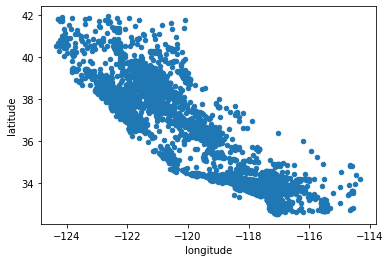

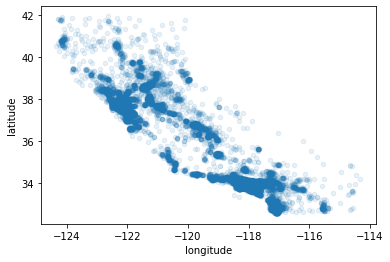

In [40]:
model(housing)